# Napsu-MQ for categorical data: Twinify usage example

In [1]:
%%capture

import jax.numpy as jnp
import numpy as np
import pandas as pd
import d3p
from twinify.napsu_mq.napsu_mq import NapsuMQModel, NapsuMQInferenceConfig, NapsuMQMCMCConfig
from twinify.napsu_mq import rubins_rules
from tests.napsu_mq.binary_logistic_regression_generator import BinaryLogisticRegressionDataGenerator
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
rng = d3p.random.PRNGKey(42526709)
data_gen_rng, inference_rng = d3p.random.split(rng)
data_gen_rng = d3p.random.convert_to_jax_rng_key(data_gen_rng)

#### Prepare dataset

Generate 10 000 rows of datapoints for logistic regression task with true coefficients (1, 3, -4, 2, 1)

In [3]:
coefficients = [1.0, 3.0, -4.0, 2.0, 1.0]
dataset = BinaryLogisticRegressionDataGenerator(jnp.array(coefficients)).generate_data(n=10000, rng_key=data_gen_rng)

In [4]:
orig_df = pd.DataFrame(dataset, dtype="category")
n, d = orig_df.shape

In [5]:
orig_df

,0,1,2,3,4,5
0,True,False,True,True,True,True
1,True,False,True,False,False,False
2,True,True,False,False,True,True
3,True,True,True,False,False,False
4,True,False,False,True,False,True
...,...,...,...,...,...,...
9995,True,False,False,True,False,True
9996,True,True,True,False,True,False
9997,True,True,False,False,False,True
9998,True,True,False,False,True,True


#### Create NapsuMQModel and fit the probabilistic model with DP

In [7]:
# Fitting the model takes few minutes

rng = d3p.random.PRNGKey(74249069)
inference_rng, sampling_rng = d3p.random.split(rng)

# We can define column marginal relationships that we want to preserve
required_marginals = [(0, 1), (0, 5), (3, 5)]


inference_config = NapsuMQInferenceConfig(
    mcmc_config=NapsuMQMCMCConfig(
        num_samples=1000
    )
)
model = NapsuMQModel(
    forced_queries_in_automatic_selection=required_marginals,
    inference_config=inference_config,
)
result = model.fit(
    data=orig_df,
    rng=inference_rng,
    epsilon=1,
    delta=(n ** (-2)),
)

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1800/1800 [00:00<00:00, 4159.91it/s, 31 steps of size 1.72e-01. acc. prob=0.92]


#### Create a synthetic dataset using probabilistic model

In [8]:
synthetic_dfs = result.generate(
    rng=sampling_rng, 
    num_data_per_parameter_sample=10000, 
    num_parameter_samples=10,
    single_dataframe=False
)

#### Plot and compare the results

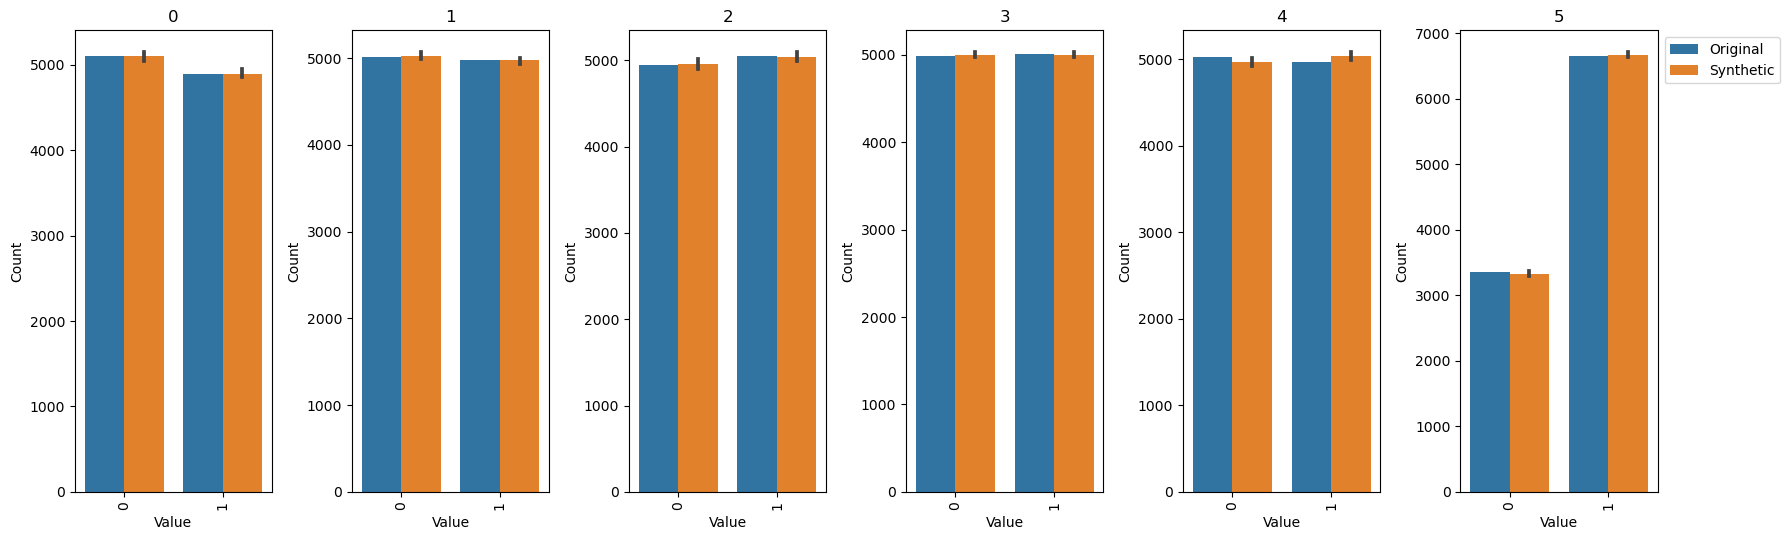

In [9]:
def value_count_list(df, col, type):
    counts = df[col].value_counts()
    return [(value, counts[value], type) for value in counts.index]

def value_count_df(orig_df, synthetic_dfs, col):
    vl_list = value_count_list(orig_df, col, "Original")
    for synthetic_df in synthetic_dfs:
        vl_list += (value_count_list(synthetic_df, col, "Synthetic"))

    return pd.DataFrame.from_records(vl_list, columns=["Value", "Count", "Type"])

value_count_dfs = { col: value_count_df(orig_df, synthetic_dfs, col) for col in orig_df.columns }

fig, axes = plt.subplots(1, len(value_count_dfs.items()), figsize=(3 * len(value_count_dfs.items()), 5.5))
for i, (key, value) in enumerate(value_count_dfs.items()):
    ax = axes[i]
    ax.set_title(key)
    ax.tick_params("x", labelrotation=90)
    sns.barplot(x="Value", y="Count", data=value_count_dfs[key], hue="Type", estimator=np.mean, ax=ax)
    if i < len(value_count_dfs.items()) - 1: 
        ax.get_legend().remove()
    else:
        ax.legend(loc="upper left", bbox_to_anchor=(1.00, 1))
        
plt.tight_layout()
plt.show()